In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import Markdown

In [2]:
dogs = pd.read_csv("psy_data.csv", header=0).set_index("dog.id")
display(dogs.head())
dog_info = pd.read_csv("psy_info.csv", header=1)
print(dogs.columns[10:100])


,breed_group,sex,sterilization_status,Noise.sensitivity_age,Fearfulness_age,Aggression_age,Surface_age,Separation_age,Impulsivity_age,Personality_age,...,Vas_8_excessive,Vas_9_alwaysplay,Vas_10_complicatedtasks,Vas_11_reacthastily,Vas_12_easilydistracted,Vas_13_cannotwait,impulsive,impulsiveness_disturbes,inattention_score,impulsivity_score
dog.id,,,,,,,,,,,,,,,,,,,,,
1,Jack_Russell_Terrier,female,sterilized,14.241650,14.181420,14.236174,14.233437,14.181420,14.236174,14.044534,...,2.0,3.0,2.0,2.0,3.0,2.0,0.0,3.0,0.993593,0.097521
2,Jack_Russell_Terrier,female,intact,8.693866,8.359294,8.693866,8.353818,NaN,8.422270,8.685652,...,2.0,3.0,1.0,1.0,2.0,2.0,NaN,2.0,-0.633266,0.904661
3,Pinschers_Schnauzers,male,intact,1.992701,1.992701,1.992701,1.992701,1.992701,1.992701,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,NaN,NaN
4,Pinschers_Schnauzers,male,sterilized,5.405751,5.405751,5.405751,5.405751,5.405751,5.405751,NaN,...,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,-0.528441,-0.822966
5,German_Shepherd_Dog,male,sterilized,3.875205,4.006568,3.875205,4.006568,4.006568,4.006568,4.006568,...,3.0,3.0,2.0,2.0,4.0,2.0,1.0,5.0,0.347356,1.438794


Index(['weight_kg', 'ownership_reason', 'obtained_from', 'age_enter_household',
       'weaning_age', 'Socialization_men', 'Socialization_women',
       'Socialization_children', 'Socialization_dogs', 'Socialization_city',
       'Socialization_car', 'Socialization_public.transportation',
       'socialization', 'socialization_quantile', 'living_place',
       'living_building', 'outdoor_access', 'other_dogs_when_obtained',
       'currently_other_dogs', 'daily_exercise', 'leashed_unleashed',
       'trains_agility', 'trains_obedience_rally', 'trains_nose_work',
       'trains_rescue_utility', 'hobby_frequency_home', 'hobby_frequency_out',
       'alone_time', 'life_experience', 'dog_experience', 'dog_breeder',
       'animal-related_work', 'Willing_to_learn', 'Playful_dogs',
       'Predictable', 'Obedient', 'Boisterous', 'Sensitive_touch', 'Vocal',
       'Anxious', 'Independent', 'Lazy', 'Intelligent', 'Reliable',
       'Prey_driven_chase', 'Human_dependent', 'Wary', 'Erratic', 'St

,weight_kg,rounded_weight,Aggressive_dogs_samegender
dog.id,,,
12089,1.00,1.0,5.0
2462,1.00,1.0,1.0
12033,1.60,1.0,4.0
14246,1.65,1.0,5.0
5371,1.80,1.0,2.0
15083,1.80,1.0,NaN
3323,2.00,2.0,4.0
6043,2.00,2.0,1.0
2818,2.00,2.0,1.0


<Axes: xlabel='rounded_weight', ylabel='Aggressive_dogs_samegender'>

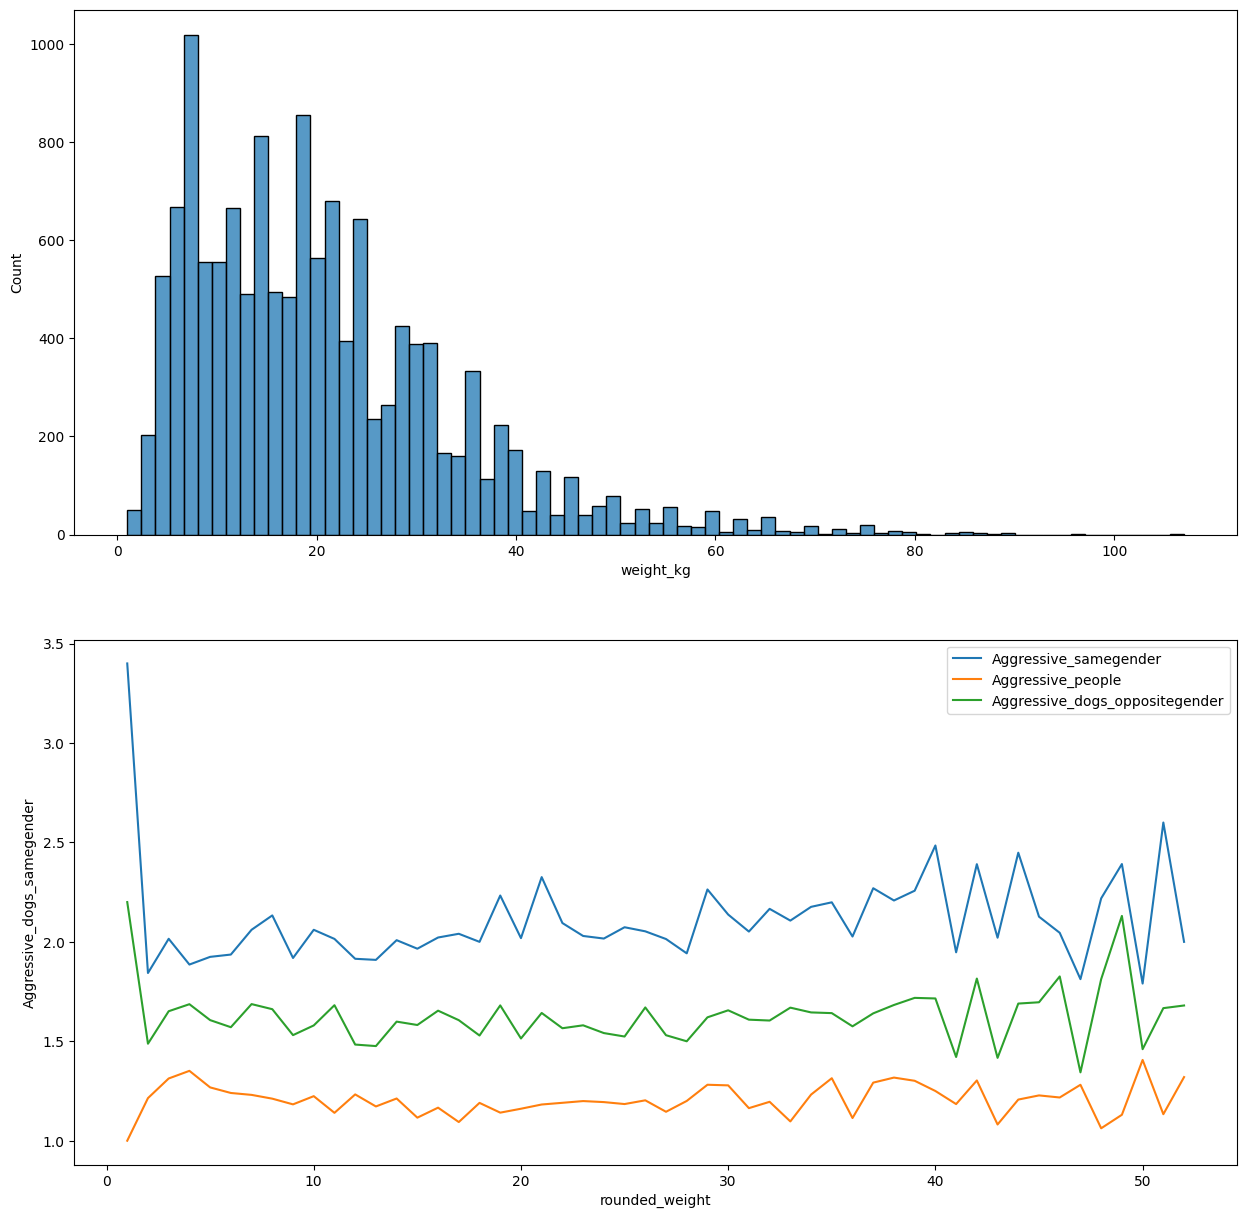

In [3]:
dogs["rounded_weight"] = np.floor(dogs["weight_kg"])
display(dogs.sort_values("weight_kg").loc[:,["weight_kg", "rounded_weight", "Aggressive_dogs_samegender"]].head(15))
q1 = dogs["rounded_weight"].quantile(0.25)
q3 = dogs["rounded_weight"].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5*iqr
upper = q3 + 1.5*iqr

figure, axes = plt.subplots(2, 1, figsize = (15, 15), sharey = False)
sns.histplot(data = dogs, x = "weight_kg", ax = axes[0])

aggression_per_weight_samegender = pd.DataFrame(dogs.query("rounded_weight > @lower and rounded_weight < @upper").groupby("rounded_weight").mean("Aggressive_dogs_samegender")["Aggressive_dogs_samegender"])
sns.lineplot(data = aggression_per_weight_samegender, x = "rounded_weight", y = "Aggressive_dogs_samegender", label = "Aggressive_samegender", ax = axes[1])

aggression_per_weight_people = pd.DataFrame(dogs.query("rounded_weight > @lower and rounded_weight < @upper").groupby("rounded_weight").mean("Aggressive_people")["Aggressive_people"])
sns.lineplot(data = aggression_per_weight_people , x = "rounded_weight", y = "Aggressive_people", label = "Aggressive_people", ax = axes[1])

aggression_per_weight_oppositegender = pd.DataFrame(dogs.query("rounded_weight > @lower and rounded_weight < @upper").groupby("rounded_weight").mean("Aggressive_dogs_oppositegender")["Aggressive_dogs_oppositegender"])
sns.lineplot(data = aggression_per_weight_oppositegender , x = "rounded_weight", y = "Aggressive_dogs_oppositegender", label = "Aggressive_dogs_oppositegender", ax = axes[1])

c:\Users\Legion\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning:

Using the countplot function without specifying `order` is likely to produce an incorrect plot.

c:\Users\Legion\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning:

Using the countplot function without specifying `order` is likely to produce an incorrect plot.

c:\Users\Legion\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning:

Using the countplot function without specifying `order` is likely to produce an incorrect plot.



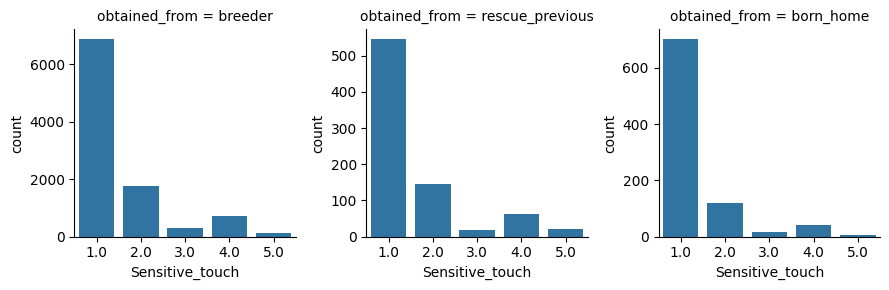

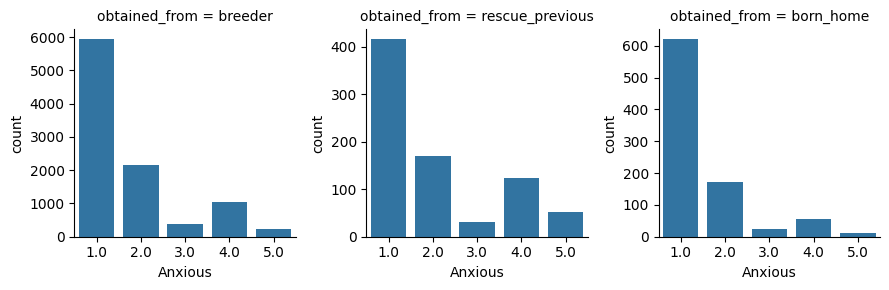

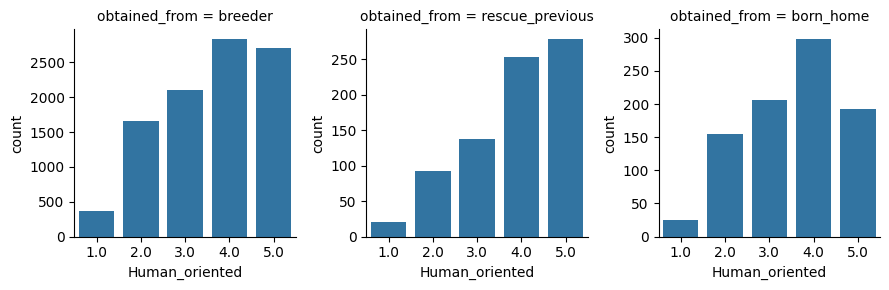

C:\Users\Legion\AppData\Local\Temp\ipykernel_10216\1007111510.py:31: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\Legion\AppData\Local\Temp\ipykernel_10216\1007111510.py:31: FutureWarning:

The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.

C:\Users\Legion\AppData\Local\Temp\ipykernel_10216\1007111510.py:39: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\Legion\AppData\Local\Temp\ipykernel_10216\1007111510.py:31: FutureWarning:

Downcasting behavior in `replace` is de

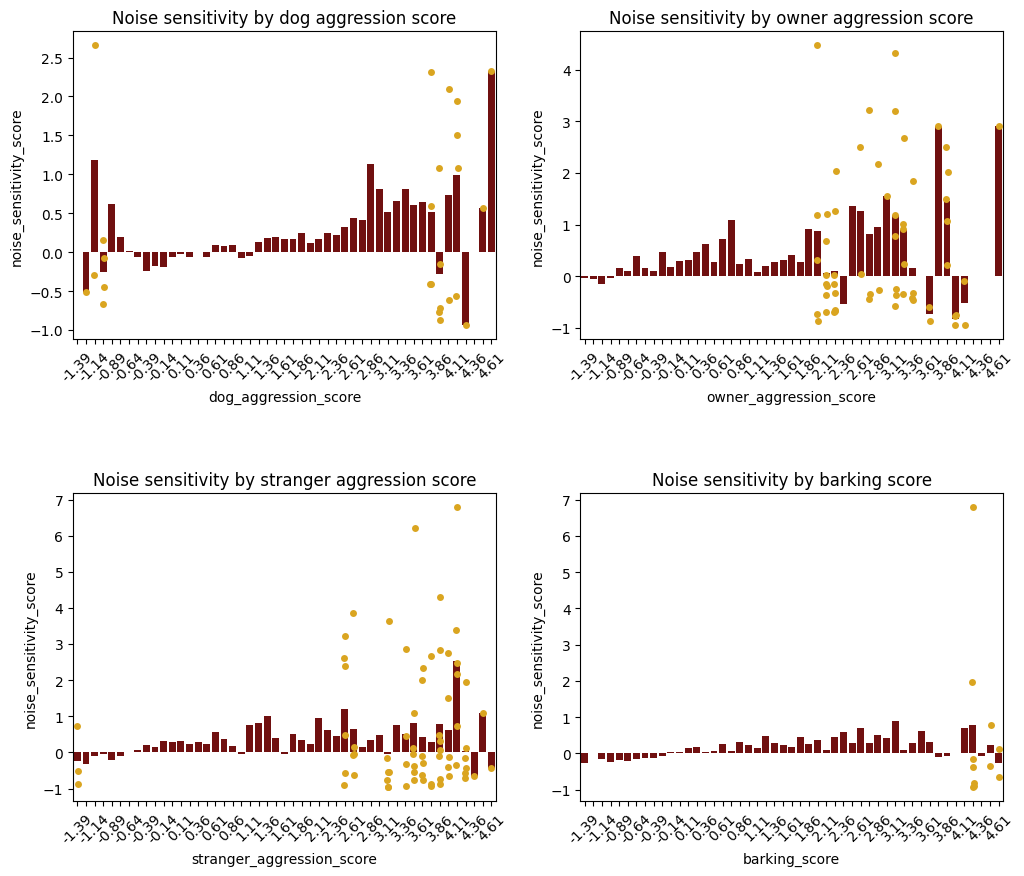

In [30]:
grid = []
grid.append(sns.FacetGrid(data=dogs, col='obtained_from', sharey=False))
grid[0].map(sns.countplot, "Sensitive_touch")

grid.append(sns.FacetGrid(data=dogs, col='obtained_from', sharey=False))
grid[1].map(sns.countplot, "Anxious")

grid.append(sns.FacetGrid(data=dogs, col='obtained_from', sharey=False))
grid[2].map(sns.countplot, "Human_oriented")

for gr in grid:
    plt.show(gr)

dogs_melted = dogs.melt(id_vars=['obtained_from'], 
                        value_vars=['Sensitive_touch', 'Anxious', 'Human_oriented'],
                        var_name='Behavior', 
                        value_name='Score')

priemery = dogs_melted.groupby(["Behavior", "obtained_from"])["Score"].mean().reset_index()

priemerydict = {}
booldict = {}
for x in ["dog_aggression_score", "owner_aggression_score", "stranger_aggression_score", "barking_score"]:
    dogs[x + "_interval"] = pd.cut(x = dogs[x], bins = np.linspace(dogs[x].min(), dogs[x].max(), 50))
    priemerydict[x] = dogs.groupby(x + "_interval", observed = False)["noise_sensitivity_score"].mean().reset_index()
    booldict[x] = dogs.reset_index().groupby(x + "_interval", observed= False)["dog.id"].count() < 10

figure, axes = plt.subplots(2, 2, figsize = (12, 10))
for i, n in enumerate(["dog_aggression_score", "owner_aggression_score", "stranger_aggression_score", "barking_score"]):
    sns.barplot(data=priemerydict[n], x = n + "_interval", y = "noise_sensitivity_score", ax = axes[i//2][i%2], color = "maroon")
    sns.stripplot(data = dogs.iloc[list(dogs[n + "_interval"].replace(booldict[n]).fillna(False)), :], x = n + "_interval", y = "noise_sensitivity_score", ax = axes[i//2][i%2], color = "goldenrod")
    labels = np.array(np.round(np.linspace(dogs[x].min(), dogs[x].max(), 50), decimals = 2), dtype = str)
    labels[1::2] = ""
    nazov = n.split("_")
    if len(nazov) == 3:
        axes[i//2][i%2].set_title(f"Noise sensitivity by {nazov[0]} {nazov[1]} {nazov[2]}")
    else:
        axes[i//2][i%2].set_title(f"Noise sensitivity by {nazov[0]} {nazov[1]}")
    axes[i//2][i%2].set_xticklabels(labels, rotation = 45)
    axes[i//2][i%2].set_xlabel(n)

figure.subplots_adjust(hspace=0.5)
px.bar(data_frame= priemery, x = "Score", y = "obtained_from", facet_col= "Behavior", facet_col_wrap=3).show()